<a href="https://colab.research.google.com/github/adag21044/PoliticalTweetAnalyzer/blob/main/PoliticalTweetAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

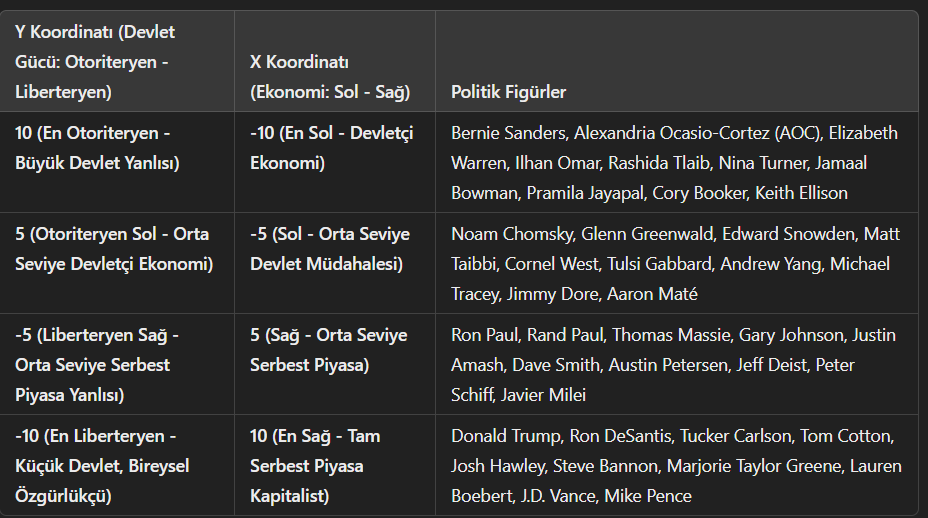

In [54]:
import re
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

In [55]:
# 1️⃣ **ÖRNEK POLİTİK VERİ SETİ**
tweets_data = {
    "authoritarian_left": [
        "The government must regulate businesses for fairness.",
        "We need higher taxes on the rich for wealth redistribution.",
        "Public healthcare is a human right, not a privilege.",
        "Strong government policies will protect the working class."
    ],
    "libertarian_left": [
        "People should be free to make their own life choices.",
        "The government should not interfere in personal matters.",
        "Decentralization of power is key to real freedom.",
        "We need a social safety net, but with personal choice."
    ],
    "authoritarian_right": [
        "Strong borders make a strong nation!",
        "Law and order must be strictly enforced.",
        "Traditional values should be the foundation of our society.",
        "Military strength is necessary for national security."
    ],
    "libertarian_right": [
        "The free market is the best path to economic growth.",
        "Less government regulation means more innovation.",
        "People should have full control over their private property.",
        "Taxation is theft! Government should be as small as possible."
    ]
}
test_tweets = [
    "We need higher taxes for the rich!",
    "Government control is too much, let people decide!",
    "America first! We must secure our borders."
]

In [56]:
# 2️⃣ **METİN TEMİZLEME**
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = re.sub(r"@\w+|#", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    return tweet

for category in tweets_data:
    tweets_data[category] = [preprocess_tweet(tweet) for tweet in tweets_data[category]]

In [57]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
bert_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base")

def get_bert_embedding(tweet):
    tokens = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=50)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()


In [59]:
# Politik görüşü net figürlerin tweetleri (tamamen elle)
datasets = {
    "(-10,10)": pd.DataFrame({   # Bernie Sanders
        "text": [
            "Healthcare is a human right.",
            "We must tax billionaires fairly.",
            "Workers deserve a living wage.",
            "Climate change is the greatest threat to humanity."
        ]
    }),
    "(-5,5)": pd.DataFrame({   # AOC
        "text": [
            "The Green New Deal is essential for our future.",
            "Public housing must be expanded and funded.",
            "Every American deserves dignified work and wages.",
            "We must challenge corporate power in Washington."
        ]
    }),
    "(5,-5)": pd.DataFrame({   # Justin Amash
        "text": [
            "The government should be as small as possible.",
            "End the Fed and return fiscal responsibility.",
            "Taxation should be minimal and transparent.",
            "Personal freedoms are the foundation of a healthy society."
        ]
    }),
    "(10,-10)": pd.DataFrame({   # Donald Trump
        "text": [
            "We will build the wall and secure our borders.",
            "Make America Great Again!",
            "America First, always.",
            "Our military is stronger than ever before."
        ]
    })
}

# =====================
# GERÇEK DATASETLER (CSV)
# =====================

real_datasets = {
    "(-10,10)": pd.read_csv("/content/Bernie_tweets.csv", on_bad_lines="skip"),
    "(-5,5)": pd.read_csv("/content/aoc_tweets.csv", on_bad_lines="skip"),
    "(10,-10)": pd.read_csv("/content/trumptweets.csv", on_bad_lines="skip")
}

# Koordinatlar
point_map = {
    "(-10,10)": (-10, 10),
    "(-5,5)": (-5, 5),
    "(5,-5)": (5, -5),
    "(10,-10)": (10, -10)
}


In [64]:
def get_tweets_from_df(df):
    for col in ["text", "body", "content"]:
        if col in df.columns:
            return df[col].dropna().tolist()
    raise ValueError("Uygun tweet sütunu bulunamadı. (text, body, content)")

# =====================
# 5️⃣ EMBEDDING ve LABELS (düzeltilmiş)
# =====================

X = []
y = []



# Real dataset embedding
for point, df in real_datasets.items():
    coords = point_map[point]
    tweets = get_tweets_from_df(df)
    for tweet in tweets:
        cleaned = preprocess_tweet(tweet)
        embedding = get_bert_embedding(cleaned)
        X.append(embedding)
        y.append(coords)

X = np.array(X)
y = np.array(y)

print("Embedding Shape:", X.shape)
print("Coordinate Shape:", y.shape)


KeyboardInterrupt: 

In [47]:
# =====================
# 6️⃣ MODEL EĞİTİMİ
# =====================
mlp = MLPRegressor(hidden_layer_sizes=(256, 128), max_iter=5000, random_state=42)
mlp.fit(X, y)
print("Model eğitildi ✅")

Model eğitildi ✅


In [48]:
# =====================
# 7️⃣ ELLE TWEET TEST
# =====================

my_tweet = "The government is getting too big and controlling everything."
cleaned_tweet = preprocess_tweet(my_tweet)
my_embedding = get_bert_embedding(cleaned_tweet).reshape(1, -1)

predicted_point = mlp.predict(my_embedding)[0]
print("Tahmin edilen pusula noktası:", predicted_point)


Tahmin edilen pusula noktası: [ 2.0245829 -2.1611843]


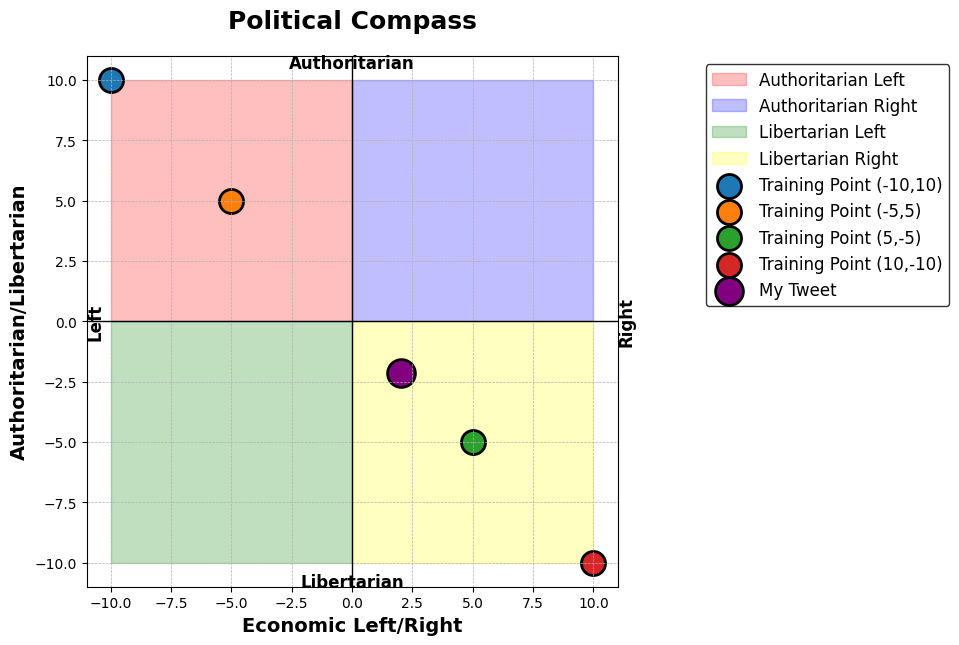

In [53]:
# =====================
# 8️⃣ Compass + Eksen İsimleri
# =====================

plt.figure(figsize=(10, 10))

# Çeyrekler
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

plt.fill_between([-10, 0], 0, 10, color="red", alpha=0.25, label="Authoritarian Left")
plt.fill_between([0, 10], 0, 10, color="blue", alpha=0.25, label="Authoritarian Right")
plt.fill_between([-10, 0], -10, 0, color="green", alpha=0.25, label="Libertarian Left")
plt.fill_between([0, 10], -10, 0, color="yellow", alpha=0.25, label="Libertarian Right")

plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.gca().set_aspect('equal', adjustable='box')

# Eksen Başlıkları
plt.xlabel("Economic Left/Right", fontsize=14, fontweight="bold")
plt.ylabel("Authoritarian/Libertarian", fontsize=14, fontweight="bold")
plt.title("Political Compass", fontsize=18, fontweight="bold", pad=20)

# Noktalar
for point, (x, y) in point_map.items():
    plt.scatter(x, y, s=300, label=f"Training Point {point}", edgecolors="black", linewidth=2)

plt.scatter(predicted_point[0], predicted_point[1], s=400, color="purple", label="My Tweet", edgecolors="black", linewidth=2)

# Eksen uçlarına isim yaz
plt.text(0, 10.5, "Authoritarian", ha="center", fontsize=12, fontweight="bold")
plt.text(0, -11, "Libertarian", ha="center", fontsize=12, fontweight="bold")
plt.text(-11, 0, "Left", va="center", fontsize=12, fontweight="bold", rotation=90)
plt.text(11, 0, "Right", va="center", fontsize=12, fontweight="bold", rotation=90)

# Legend dışarı
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=12, frameon=True, edgecolor="black")

plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
